In [43]:
# Make One Big String so the model can learn its cohesive structre for next token, etc.
import pandas as pd

# Load your dataset
df = pd.read_csv("Songs/OUTPUTS/AllSongs_Cleaned.csv", sep='\t', encoding='utf-8')

# Optional: sort if necessary (you want the original order of words)
#df = df.sort_values(by=['line_number', 'token_number'])

# Concatenate into a single string
text = ' '.join(df['chunk_str'].astype(str).tolist())

# Let's see what it looks like
print(text[:300])

nan 'Duke  Duke  Duke  Duke of Earl' 'Duke  Duke  Duke of Earl' 'Duke  Duke  Duke of Earl' 'Duke  Duke  Duke of Earl' 'Duke  Duke  Duke of Earl' 'Duke  Duke  Duke of Earl' 'Duke  Duke  Duke of Earl' 'Duke  Duke  Duke of Earl' 'As I walk through this world' 'Nothing can stop the Duke of Earl' 'And-a 


In [44]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from torch.utils.data import Dataset

# Load pre-trained tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Optional: Add special tokens if needed
tokenizer.pad_token = tokenizer.eos_token  # GPT2 doesn't have a pad token, just reuse eos

# Tokenize your text
tokens = tokenizer(text, return_tensors='pt', truncation=True)

# Check out the size
print(tokens['input_ids'].shape)

c:\Users\grozz\miniconda3\envs\gemcordelli\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 1024])


In [45]:
class LyricsDataset(Dataset):
    def __init__(self, tokens, block_size=128):
        self.input_ids = tokens['input_ids'][0]
        self.block_size = block_size

    def __len__(self):
        return len(self.input_ids) - self.block_size

    def __getitem__(self, idx):
        x = self.input_ids[idx:idx + self.block_size]
        y = self.input_ids[idx + 1:idx + 1 + self.block_size]
        return x, y

dataset = LyricsDataset(tokens, block_size=64)

In [17]:
from transformers import GPT2LMHeadModel
from torch.optim import AdamW

model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))  # adjust vocab size if you changed it
model.train()

optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop (tiny version)
for epoch in range(3):
    for i in range(0, len(dataset), 32):  # batch of 32
        batch = [dataset[j] for j in range(i, min(i + 32, len(dataset)))]
        x_batch = torch.stack([item[0] for item in batch])
        y_batch = torch.stack([item[1] for item in batch])

        outputs = model(input_ids=x_batch, labels=y_batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 256 == 0:
            print(f"Epoch {epoch} | Step {i} | Loss: {loss.item():.4f}")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 0 | Step 0 | Loss: 7.1051
Epoch 0 | Step 256 | Loss: 5.7210
Epoch 0 | Step 512 | Loss: 5.7310
Epoch 0 | Step 768 | Loss: 6.0344
Epoch 1 | Step 0 | Loss: 3.8072
Epoch 1 | Step 256 | Loss: 4.8660
Epoch 1 | Step 512 | Loss: 4.8592
Epoch 1 | Step 768 | Loss: 5.1227
Epoch 2 | Step 0 | Loss: 3.4993
Epoch 2 | Step 256 | Loss: 4.0413
Epoch 2 | Step 512 | Loss: 3.9977
Epoch 2 | Step 768 | Loss: 4.1741


In [23]:
model.eval()
prompt = "love is"
inputs = tokenizer(prompt, return_tensors='pt')
outputs = model.generate(inputs['input_ids'], max_length=50, do_sample=True, top_k=40)
print(tokenizer.decode(outputs[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


love is  You your  You wanna it' Cause butt  round   round  to waist - round round    To your round' 'm of -ake I it  And't me't  I of


### Let's Clean a Bit More

In order to better understand our data, and eventually add more songs for a more livelu (and accurate) chatbot, let's...
    
    - normalize our words (get rid of trailing regexes that will mess up our pos tagger)

    - add a title column (to differentiate sentiment from song to song)

    - *Down the line, we want to do the same for the bottom 100 songs from the top 100, and look for differences in parameter quality*



In [46]:
import pandas as pd
TOKENS = pd.read_csv("Songs/OUTPUTS/TOKENS_AllSongs.csv", sep=',', encoding='utf-8')

In [47]:
TOKENS.head()

,Line_id,Song_id,Token_num,token_str
0,1,Song 0,0,'Duke
1,1,Song 0,1,Duke
2,1,Song 0,2,Duke
3,1,Song 0,3,Duke
4,1,Song 0,4,of


### 1) Normalize token_str

In [48]:
import re

# Clean punctuation from token_str
TOKENS['token_str'] = TOKENS['token_str'].str.replace(r"^[^\w]+|[^\w]+$", "", regex=True)

### 2) Adding Song Title

In [49]:
song_map = {
    'Song 0': 'Duke of Earl',
    'Song 1': 'Love in This Club',
    'Song 3' : 'Bump, Bump, Bump',
    'Song 4': 'Maria Maria',
    'Song 5': 'Baby Got Back',
    'Song 6' : 'Get Busy',
    'Song 7' : 'Bump, Bump, Bump',
    'Song 8' : 'Let Me Love You',
    'Song 9': 'My Love',
    'Song 10' : 'Only Girl (In The World)',
    'Song 11' : 'Bennie',
    'Song 12' : 'Shake It Off',
    'Song 13' : 'Slow Jamz',
    'Song 14' : 'The Streak',
    # Add more as needed
}

TOKENS['alt_id'] = TOKENS['Song_id'].map(song_map)

In [50]:
TOKENS

,Line_id,Song_id,Token_num,token_str,alt_id
0,1,Song 0,0,Duke,Duke of Earl
1,1,Song 0,1,Duke,Duke of Earl
2,1,Song 0,2,Duke,Duke of Earl
3,1,Song 0,3,Duke,Duke of Earl
4,1,Song 0,4,of,Duke of Earl
...,...,...,...,...,...
7985,898,Song 14,1,at,The Streak
7986,898,Song 14,2,that,The Streak
7987,898,Song 14,3,look,The Streak
7988,898,Song 14,4,at,The Streak


### Tag Our TOKEN TABLE for POS Using SpaCy

In [51]:
import spacy
import pandas as pd

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Example: assuming you have your DataFrame of tokens
# and want to re-assemble them per line
line_texts = TOKENS.groupby('Line_id')['token_str'].apply(lambda x: ' '.join(x))

# Process each line with spaCy
pos_results = []

for line_id, line_text in line_texts.items():
    doc = nlp(line_text)
    for token in doc:
        pos_results.append({
            'Line_id': line_id,
            'token_str': token.text,
            'pos': token.tag_,
            'lemma': token.lemma_
        })

# Convert to DataFrame
tagged_df = pd.DataFrame(pos_results)

In [52]:
tagged_df.head()

,Line_id,token_str,pos,lemma
0,1,Duke,NNP,Duke
1,1,Duke,NNP,Duke
2,1,Duke,NNP,Duke
3,1,Duke,NNP,Duke
4,1,of,IN,of


### Merge With TOKENS

In [53]:
tagged_df['Token_num'] = tagged_df.groupby('Line_id').cumcount()
TOKENS = TOKENS.merge(tagged_df, on=['Line_id', 'Token_num'], how='left')

In [54]:
TOKENS = TOKENS.set_index(['Line_id', 'Song_id', 'alt_id'])

### Add Sentiment Lexicon ~ SALEX

In [63]:
SALEX = pd.read_csv("salex_nrc.csv").set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]

In [73]:
SALEX

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,
abandon,0,0,0,1,0,1,0,1,0,0,-1
abandoned,1,0,0,1,0,1,0,1,0,0,-1
abandonment,1,0,0,1,0,1,0,1,1,0,-1
abduction,0,0,0,1,0,1,0,1,1,0,-1
aberration,0,0,1,0,0,1,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
young,0,1,0,0,1,0,1,0,1,0,1
youth,1,1,0,1,1,0,1,0,1,0,1
zeal,0,1,0,0,1,0,1,0,1,1,1


In [65]:
TOKENS.rename(columns={'token_str_x': 'term_str'}, inplace=True)

emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()
TOKENS = TOKENS.join(SALEX, on='term_str', how='left')
TOKENS[emo_cols] = TOKENS[emo_cols].fillna(0)

In [86]:
TOKENS[['term_str'] + emo_cols].sample(10)

Let_Me_Love_You = TOKENS.xs(('Let Me Love You', 'Song 8'), level=('alt_id', 'Song_id'))
Only_Girl = TOKENS.xs(('Only Girl (In The World)', 'Song 10'), level=('alt_id', 'Song_id'))

<Axes: >

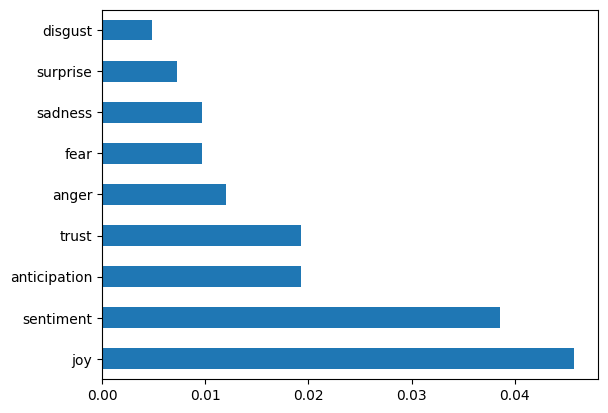

In [84]:
Let_Me_Love_You[emo_cols].mean().sort_values(ascending=False).plot.barh()

<Axes: >

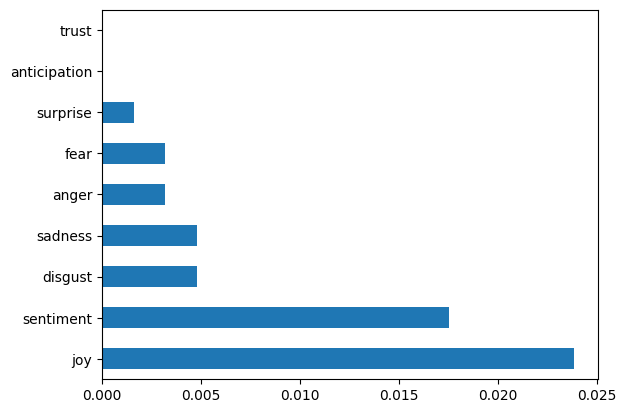

In [87]:
Only_Girl[emo_cols].mean().sort_values(ascending=False).plot.barh()